In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from theano import shared
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az
plt.style.use('arviz-darkgrid')

La música, ya sea la Suite para violonchelo N° 1 de Bach, _el pibe cantina_ de damas gratis o Libertango de Piazzolla se construye con patrones recurrentes. Las mismas escalas, progressiones de acordes, riffs, etc aparecen una y otra vez dando lugar a un maravilloso paisaje sonoro capaz de provocar y modular toda la gama de emociones humanas. De manera similar, el universo estadístico está compuesto de patrones recurrentes, pequeños motivos que aparecen una y otra vez. En este capítulo, vamos a ver uno de los más populares y útiles de ellos, el modelo lineal. Este es un modelo muy útil en sí mismo y también el componente básico de muchos otros modelos. Es probable que algunos de los siguientes términos te resulten familiares: regresión lineal simple, regresión múltiple, regresión logística, ANOVA, ANCOVA. Todos estos métodos son variaciones del mismo motivo subyacente, el modelo de regresión lineal. En este capítulo, cubriremos los siguientes temas:

* Regresión lineal simple Simple linear regression
* Regresión lineal robusta
* Regresión jerárquica 
* Regresión polinomial
* Regresión múltiple
* Interacciones
* Varianza variable

# Regresión lineal

Supongamos que tenemos una variable $x$, y a partir de esta queremos predecir o modelar una variable $y$. Además, estás variables se encuentran apareadas $\{(x_1,y_1), (x_2,y_2), (x_3,y_3),\dots (x_n,y_n)\} $.
En el caso más simple $x$ e $y$ son variables aleatorias continuas y unidimensionales, usando Python las representaríamos usando _arrays_ de dimensión 1 de tipo flotante. 

Dependiendo de las autoras y las disciplinas científicas la variable $y$ suele recibir distintos nombres como variable dependiente, predicha o respuesta, mientras que $x$ recibe nombres como variable independiente, predictora o _de entrada_. En _Machine learning_ es común hablar de _features_ en vez de variables y es común pensar que una regresión lineal es un ejemplo de [aprendizaje supervisado](https://es.wikipedia.org/wiki/Aprendizaje_supervisado).

Cuando tenemos más de una variable independiente es común representarla como una matriz $X$ (usualmente llamada [matriz de diseño](https://en.wikipedia.org/wiki/Design_matrix)), donde por lo general las filas representan distintos tipos de variables (o _features_) y las columnas contienen las _n_ observaciones. Este tipo de modelo se llama regresión lineal múltiple o regresión lineal multivariable y es quizá el caso más común de regresión lineal. El nombre regresión lineal multivariada debería reservarse a casos en que tenemos más de una variable respuesta, aunque es muy común en literatura que estos términos se confundan.


Algunos ejemplos donde se pueden usar modelos de regresión lineal:

* Modelar la relación entre factores como la lluvia, la salinidad del suelo y la presencia de fertilizante en la productividad de los cultivos. Podríamos tener interés en preguntas como: ¿Es lineal la relación? ¿Qué tan fuerte es esta relación? ¿Cuál variable explica la mayor parte del efecto?
* Encontrar una relación lineal entre el consumo promedio de chocolate por país y la cantidad de premios Nobel en cada país. Y luego entender por qué esta relación podría ser espuria.
* Predecir el monto de la factura de gas de tu casa a partir de la variable radiación solar. ¿Cuán precisa es esta predicción?

Habiendo ya discutido algunas ideas generales sobre regresión lineal veamos como es que este modelo se construye. Podemos describir una relación lineal usando la siguiente expresión:

$$y_i = \alpha + x_i \beta  \tag{3.1}$$


El parámetro $\beta$ controla la pendiente en la relación lineal y, por lo tanto, podemos interpretarlo como el cambio en la variable $y$ por cambio de unidad en la variable $x$. El parámetro $\alpha$ se conoce como intercepto u ordenada al origen, y podemos interpretarlo como el valor de $y_i$ cuando $x_i = 0$. Gráficamente, $\alpha$ indica el valor de $y_i$ donde la línea intercepta el eje y.


Un método muy popular de encontrar los parámetros para un modelo lineal se conoce como ajuste por mínimos cuadrados y es un método de optimización, es decir un método que encuentra el mínimo o máximo de una función. Este método devuelve los valores de $\alpha$ y $\beta$ que minimizan el error cuadrático promedio $y$ observado y el $y$ predicho.

La expresión 3.1 puede ser reformulada de forma probabilística:

$$y \sim \mathcal{N}(\mu=\alpha + x \beta, \epsilon) \tag{3.2}$$

Es decir $y$ es una variable aleatoria distribuida según una Gaussiana con media $\alpha + x \beta$ desviación estándar $\epsilon$. Desde esta perspectiva una regresión lineal es una extensión de un modelo Gaussiano donde en vez de estimar la media de forma directa la calculamos como una una función lineal de las variables predictoras.

Como desconocemos los valores de los parámetros $\alpha$, $\beta$ y $\epsilon$ debemos asignarles distribuciones _a priori_. Si usáramos _a prioris_ planos entonces el valor _máximo a posteriori_ (la moda del posterior) sería el mismo que el encontrado usando _maximum likelihood_. En general es posible hacer algo mejor que esto.  Una elección razonable y genérica sería para los _a prioris_ sería:

$$
\alpha \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\beta \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\epsilon \sim |{N}(0, \sigma_\epsilon)| \tag{3.3} 
$$

Si no tenemos una idea muy clara sobre que valores deberían tener los _a prioris_ podemos fijar los valores de $\sigma_{\alpha}$, $\sigma_{\beta}$ o $\sigma_{\epsilon}$ de forma tal que sean _grandes_ dada la escala de los datos. En general es más fácil tener una idea de los valores que $\beta$ puede tomar por sobre los de $\alpha$, por ejemplo solemos saber si la pendiente es positiva o negativa. Usar datos estandarizados suele ser útil para elegir _a prioris_ ligeramente informativos que funciona para un amplio rango de problemas.

Para parámetros como $\epsilon$, que están restringidos a los positivos es común el uso de _a prioris_ como la media Gaussiana (como en 3.3), algunas alternativas son la distribución uniforme y la media-Cauchy, mientras que la media-gaussiana y la media-Cauchy funcionan bien como _a prioris_ generales, la distribución uniforme no suele ser buena idea, en general no es buena idea usar distribuciones restringidas a un rango salvo que sepamos que los parámetros realmente están restringidos a ese rango. La distribución gamma se puede usar para definir _a prioris_ más informativos para $\epsilon$, especialmente si la definimos usando la media y desviación estándar, PyMC3 permite definir una distribución Gamma usando dos [parametrizaciones alternativas](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Gamma).

Usando diagramas de Krusche podemos representar una regresión lineal de la siguiente forma:


$\mu$ está definida usando el símbolo $=$, en vez de $\sim$, esto se debe a que una vez conocidos $\alpha$ y $\beta$ el valor de $\mu$ queda completamente determinado. Llamamos a este tipo de variables deterministas.


Ahora necesitamos los datos para alimentar el modelo. Una vez más, vamos a confiar en un conjunto de datos sintéticos. Una ventaja de un conjunto de datos sintético es que conocemos los valores correctos de los parámetros y, por lo tanto, podemos verificar si podemos recuperarlos con nuestros modelos.

In [2]:
np.random.seed(1)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alfa_real + beta_real * x 
y = y_real + eps_real

# we can center the data
#x = x - x.mean()
# or standardize the data
#x = (x - x.mean())/x.std()
#y = (y - y.mean())/y.std()

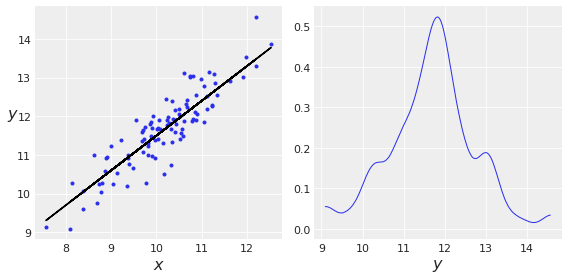

In [3]:
_, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('$x$', fontsize=16)
ax[0].set_ylabel('$y$', fontsize=16, rotation=0)
ax[0].plot(x, y_real, 'k')
az.kdeplot(y, ax=ax[1])
ax[1].set_xlabel('$y$', fontsize=16)
plt.tight_layout()

Escribir este modelo en PyMC3 es bastante directo, la única diferencia con los modelos anteriores es que ahora hemos especificado a la variable $\mu$ como una variable determinista. Una variable determinista tendrá una distribución _a posteriori_ ya que es función de al menos una variable estocástica. Si en PyMC3 especificamos un variable como determinista esta será incluida en el `trace`. Alternativamente podríamos haber escrito:

```python
μ = α + β * x
```

Esto es igualmente válido, la única diferencia es que en este caso la variable $\mu$ no estaría incluida en el `trace`

In [4]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    
    trace_g = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:11<00:00, 526.60draws/s]


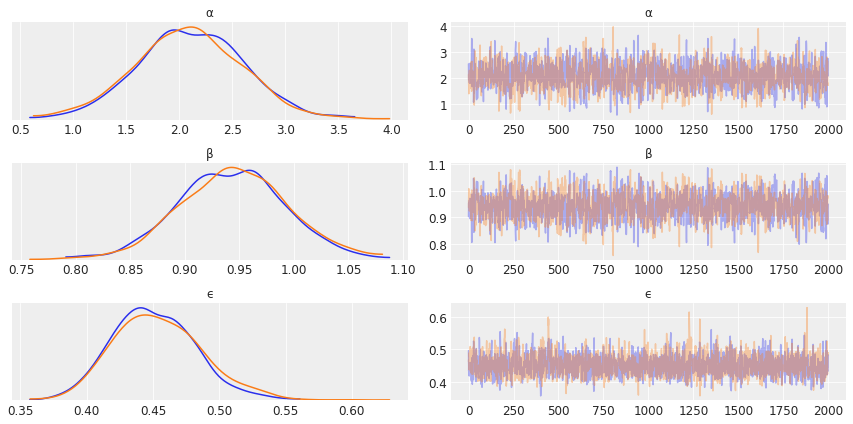

In [5]:
az.traceplot(trace_g, var_names=['α', 'β', 'ϵ']);

## Modelos lineales y autocorrelación

En un modelo lineal los parámetros $\alpha$ y $\beta$ están correlacionados.  Esto se puede ver en la siguiente figura:

/home/osvaldo/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


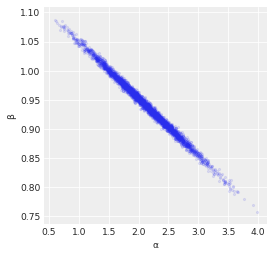

In [8]:
az.pairplot(trace_g, var_names=['α', 'β'], plot_kwargs={'alpha':'0.1'});

Esta correlación es una consecuencia directa de nuestras suposiciones. En general al hacer una regresión lineal Bayesiana las lineas que ajustan los datos pasan aproximadamente por la media de $x$ y la media de $y$, además el aumento en la pendiente significa la disminución de la ordenada al origen y viceversa. Esto provoca que el posterior para $\alpha$ y $\beta$ sea _un espacio muy diagonal_. Esto puede ser problemático para métodos como Metropolis-Hastings y, en menor medida para NUTS.

Un método simple para eliminar la correlación entre $\alpha$ y $\beta$ consiste en centrar la variable $x$, para esto calculamos su media y se la restamos a cada valor, obteniendo así $x'$. Como resultado la media de $x'$ será 0, si usamos $x'$ como variable dependiente $\alpha$ deberá estar alrededor de 0 y además las lineas que sean solución al problema _pivotearán_ alrededor de 0 por lo que los cambios de $\beta$ tendrán poco efecto en los valores de $\alpha$ esto provoca que el posterior para $\alpha$ y $\beta$ sea _más circular_ y menos correlacionado. Esto lo pueden comprar ustedes mismos si vuelven a correr el modelo anterior, pero esta vez centrando los datos.

Centrar datos no es solo un truco computacional, también puede ser un truco estadístico que ayuda a interpretar los resultados. $\alpha$ es el valor de $y_i $ cuando $x_i = 0$. Para muchos problemas, esta interpretación no tiene ningún sentido. Por ejemplo, para cantidades tales como la altura o el peso, los valores de cero no tienen sentido. En cambio, al centrar las variables, $\alpha$ se convierte en el valor de $y_i$ para el valor medio de $x$. Para algunos problemas, puede ser útil estimar $\alpha$ precisamente porque no es factible medir experimentalmente el valor de $x_i = 0$ y, por lo tanto, $\alpha$ puede proporcionarnos información valiosa, pero las extrapolaciones tienen sus advertencias, así que tenga cuidado cuando haces esto!


Es posible que deseemos informar los parámetros estimados en términos de los datos centrados o en términos de datos _descentrados_, la decisión dependerá del problema y de la audiencia. Si necesitamos informar los parámetros como si hubiesen sido determinados en la escala original, podemos hacer lo siguiente para devolverlos a esa escala:

$$\alpha = \alpha' - \beta' \bar x \tag{3.5}$$

Esta corrección es el resultado del siguiente razonamiento algebraico:

$$
y =\alpha' + \beta'x' + \epsilon \\
y =\alpha' + \beta'(x - \bar x) + \epsilon \\
y =\alpha' - \beta' \bar x + \beta'  x + \epsilon \\ \tag{3.6}
$$

Luego se deduce que la ecuación 3.5 es verdadera y también:

$$\beta = \beta' \tag{3.7}$$


Otra transformación que puede ser útil es estandarizar los datos. Esta transformación es una práctica común para los modelos de regresión lineal tanto en estadística y _machine learning_, ya que muchos algoritmos se comportan mejor cuando los datos están estandarizados. Esta transformación se logra al centrar los datos y dividirlos por la desviación estándar. Matemáticamente tenemos:

$$
x' = \frac{x - \bar x}{x_{sd}} \\
y' = \frac{y - \bar y}{y_{sd}} \tag{3.8} 
$$


Una ventaja de la estandarización de los datos es que siempre podemos usar los mismos priors débilmente informativos, sin tener que pensar en la escala de los datos. Para datos estandarizados, la intersección siempre será alrededor de 0 y la pendiente estará restringida al intervalo [-1, 1]. Estandarizar los datos nos permite hablar en términos de Z-score, es decir, en unidades de desviaciones estándar. Si alguien dice que el valor de un parámetro es -1.3 unidades de Z-score, sabemos automáticamente que el valor en cuestión es 1.3 desviaciones estándar por debajo del valor de la media (aún cuando no sepamos cual es el valor de la media). Un cambio en una unidad Z-score es un cambio en una desviación estándar cualquiera sea la escala original de los datos. Los Z-zcore también son muy útiles cuando se trabaja con muchas variables; ya que tener todas las variables en una misma escala puede simplificar la interpretación de los datos.

## Interpretando y visualizando el posterior


Como ya hemos visto, podemos explorar el posterior usando funciones de ArviZ como `traceplot` y `summary`, o podemos usar nuestras propias funciones. Para una regresión lineal, podría ser útil dibujar la línea promedio que ajusta los datos junto con los valores promedio de $\alpha$ y $\beta$. Para reflejar la incertidumbre contenida en la distribución _a posteriori_, podemos usar líneas semitransparentes muestreadas de esta distribución:

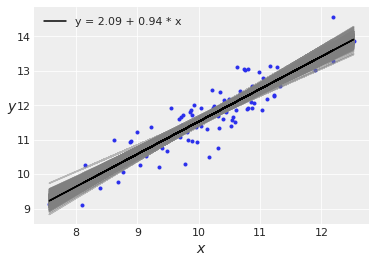

In [9]:
plt.plot(x, y, 'C0.');

alpha_m = trace_g['α'].mean()
beta_m = trace_g['β'].mean()

idx = range(0, len(trace_g['α']), 10)
plt.plot(x, trace_g['α'][idx] + trace_g['β'][idx] *  x[:,np.newaxis], c='gray', alpha=0.5);

plt.plot(x, alpha_m + beta_m * x, c='k',
         label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

plt.xlabel('$x$')
plt.ylabel('$y$', rotation=0)
plt.legend();

En la figura anterior se puede ver que la incertidumbre es menor en el medio, aunque no se reduce a un solo punto, es decir, la distribución a posteriori es compatible con las líneas que no pasan exactamente por la media de los datos, como ya hemos mencionado.

Una alternativa a muestrear lineas de la distribución a posteriori es dibujar una banda semitransparente que represente un intervalo HPD de $\mu$. Al haber definido la variable $\mu$ como determinista en el modelo, podemos hacer esto de forma sencilla:

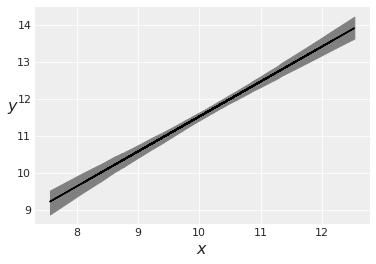

In [10]:
plt.plot(x, alpha_m + beta_m * x, c='k',
         label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

idx = np.argsort(x)
x_ord = x[idx]
sig = pm.hpd(trace_g['μ'], alpha=.02)[idx]
plt.fill_between(x_ord, sig[:,0], sig[:,1], color='gray')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0);

Una tercera opción es representar el HPD de los datos predichos (en vez de algún parámetro). En la siguiente figura sea usa un gris más oscuro para el HPD 50 y un gris más claro para el HPD 96. PAra poder hacer el siguiente gráfico necesitamos, primero, obtener las muestras predictivas posteriores. Lo cual es fácil usando PyMC3 con la función `sample_ppc`:


In [11]:
ppc = pm.sample_ppc(trace_g, samples=2000, model=model_g)

/home/osvaldo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 2000/2000 [00:01<00:00, 1435.62it/s]


Y ahora si la figura

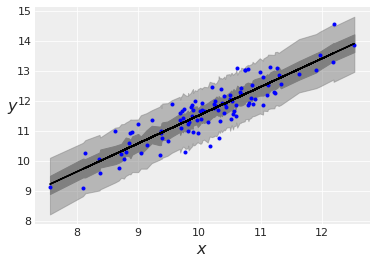

In [12]:
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

sig0 = pm.hpd(ppc['y_pred'], alpha=0.5)[idx]
sig1 = pm.hpd(ppc['y_pred'], alpha=0.05)[idx]
plt.fill_between(x_ord, sig0[:,0], sig0[:,1], color='gray', alpha=1)
plt.fill_between(x_ord, sig1[:,0], sig1[:,1], color='gray', alpha=0.5)

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0);

La apariencia irregular de los límites del HPD proviene del hecho de que estamos tomando muestras predictivas a posteriori para los valores observados de $x$ y no de un intervalo continuo de valores. Además, `fill_between`, simplemente está haciendo una interpolación lineal simple entre puntos sucesivos. Observe cómo el dibujo es más irregular en la parte central donde hay más puntos que en los extremos donde hay menos. El aspecto aserrado se puede minimizar tomando más muestras de `y_pred`.

## Regresión lineal robusta


Asumir que los datos siguen una distribución gaussiana es perfectamente razonable en muchas situaciones. Al asumir Gaussianidad, no necesariamente estamos aceptando que los datos son gaussianos; en cambio, estamos diciendo que es una aproximación razonable para un problema determinado. Como vimos en el capítulo anterior, a veces esta suposición gaussiana falla, por ejemplo, en presencia de valores aberrantes. Aprendimos que el uso de la distribución t de Student es una forma de tratar de manera efectiva con valores atípicos y obtener una inferencia más robusta. La misma idea se puede aplicar a la regresión lineal y para ejemplificarla vamos a utilizar un conjunto de datos muy simple: el tercer grupo de datos del [cuarteto de Anscombe](https://en.wikipedia.org/wiki/Anscombe%27s_quartet)

In [13]:
ans = pd.read_csv('datos/anscombe.csv')
x_3 = ans[ans.group == 'III']['x'].values
y_3 = ans[ans.group == 'III']['y'].values
x_3 = x_3 - x_3.mean()

Y ahora veamos cómo luce este pequeño conjunto de datos:

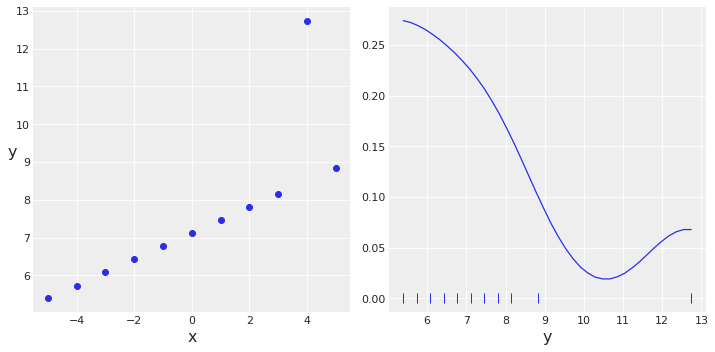

In [14]:
_, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(x_3, y_3, 'C0o')
ax[0].set_xlabel('x', fontsize=16)
ax[0].set_ylabel('y', rotation=0, fontsize=16)
az.kdeplot(y_3, ax=ax[1], rug=True)
ax[1].set_xlabel('y', fontsize=16)
plt.tight_layout();

Ahora vamos a reescribir el `modelo_g` esta vez usando una distribución t de Student en lugar de una Gaussiana. Este cambio también introduce la necesidad de especificar el valor de $\nu$, el parámetro de normalidad. Si no recuerdas la función de este parámetro, consultá el capítulo anterior antes de continuar.

En el siguiente modelo estamos usando una distribución exponencial _desplazada_, para evitar valores de $\nu$ cercanos a cero. La exponencial _no desplazada_ pone demasiado peso en valores cercanos a cero y esto puede traer algunos problemas. En el casos del tercer conjunto de datos de Anscombe _lo problemático_ deriva de que es posible ajustar una recta de forma perfecta (si obviamos el dato aberrante). Como regla general los _priors_ usados en este curso suelen ser buenos valores por defecto, pero nada más que eso. Otra distribución a _priori_ comunmente usada para $\nu$ es `gamma(2, 0.1)` o `gamma(mu=20, sd=15)`.

In [15]:
with pm.Model() as model_t:
    α = pm.Normal('α', mu=y_3.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1)
    
    y_pred = pm.StudentT('y_pred', mu=α + β * x_3,
                         sd=ϵ, nu=ν, observed=y_3)
    
    trace_t = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_, ϵ, β, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:05<00:00, 959.40draws/s] 


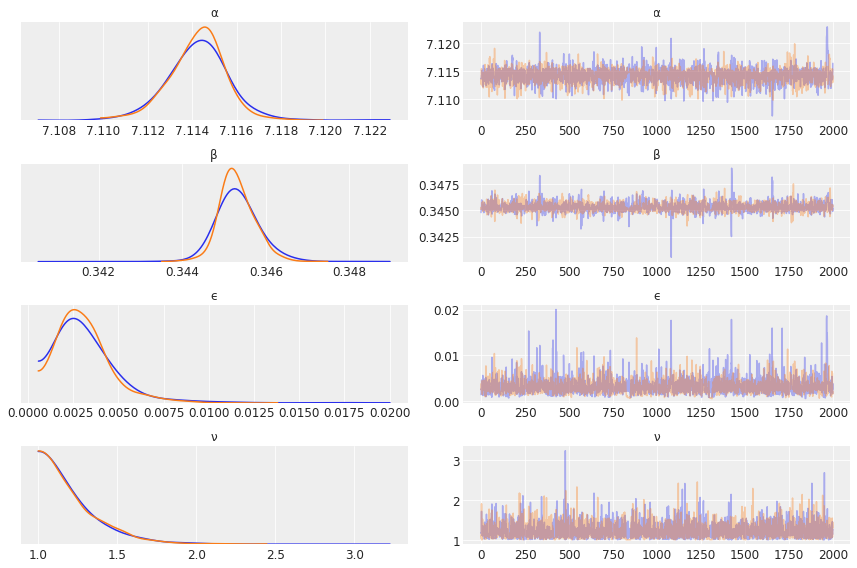

In [16]:
var_names = ['α', 'β', 'ϵ', 'ν']
az.traceplot(trace_t, var_names=var_names);

En la siguiente gráfica podemos ver el ajuste robusto, según `model_t`, y el ajuste no robusto de acuerdo con la función `linregress` de SciPy (esta función realiza una regresión por mínimos cuadrados). Como ejercicio, puede intentar agregar a esta gráfica la mejor línea obtenida usando `model_g`.

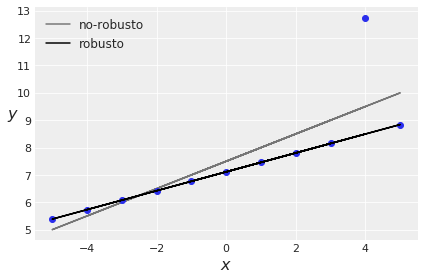

In [17]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='no-robusto', alpha=0.5)
plt.plot(x_3, y_3, 'C0o')
alpha_m = trace_t['α'].mean()
beta_m = trace_t['β'].mean()
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robusto')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=2, fontsize=12)
plt.tight_layout();

La figura anterior se puede explicar por que una distribución de t, con sus colas más pesadas, es capaz de dar menos importancia a los puntos que están alejados del _grupo principal_ de datos. En cambio el ajuste no robusto _se esfuerza_ por incluir a todos los puntos. SI bien este es un conjunto muy particular de datos el mensaje es válido para datos más complejos y _reales_ 

Antes de continuar tómese un momento para contemplar los valores de los parámetros (estoy omitiendo los parámetros intermedios ya que no es de interés directo).

Antes de continuar tómemonos un momento para contemplar los valores de los parámetros según la distribución a posteriori.

In [18]:
az.summary(trace_t, var_names)

<xarray.Dataset>
Dimensions:  (metric: 7)
Coordinates:
  * metric   (metric) <U22 'mean' 'standard deviation' 'mc error' ...
Data variables:
    α        (metric) float64 7.114 0.001336 2.365e-05 7.112 7.117 1.832e+03 1.0
    β        (metric) float64 0.3453 0.0004539 9.501e-06 0.3445 0.3462 ...
    ϵ        (metric) float64 0.00322 0.001736 4.856e-05 0.0007664 0.006105 ...
    ν        (metric) float64 1.214 0.2004 0.003469 1.0 1.562 3.38e+03 1.0

Como pueden ver, los valores de $\alpha$, $\beta$ y $\epsilon$ practicamente no tienen variación, incluso $\epsilon$ es prácticamente 0. Esto es totalmente razonable dado que estamos ajustando una línea recta a un perfecto conjunto alineado de puntos (si ignoramos el punto atípico).

## Regresión lineal jerárquica

En el capítulo anterior, aprendimos los rudimentos de los modelos jerárquicos. Este mismo concepto se puede aplciar a las regresiones lineales. Esto permite que los modelos realicen inferencias a nivel de subgrupo y a nivel global. Como ya vimos, esto se hace incluyendo hiperpriors.

Vamos a crear ocho grupos de datos relacionados, incluido uno con un solo dato

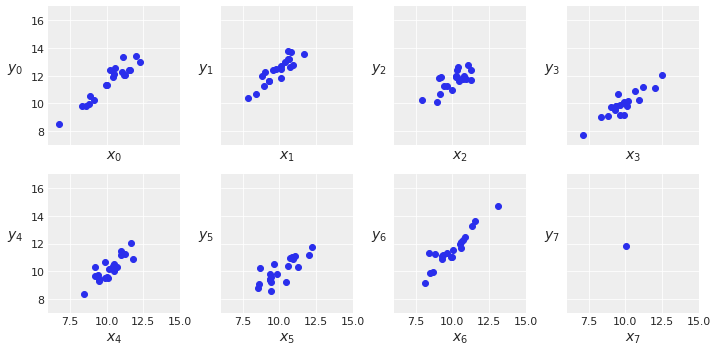

In [19]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alfa_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alfa_real[idx] + beta_real[idx] * x_m  + eps_real

_, ax = plt.subplots(2, 4, figsize=(10,5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel('$x_{}$'.format(i))
    ax[i].set_ylabel('$y_{}$'.format(i), rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N
plt.tight_layout();

Now we are going to center the data before feeding it to the model:

In [20]:
x_centered = x_m - x_m.mean()

In [21]:
with pm.Model() as hierarchical_model:
    # hyper-priors
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sd=10)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 10)
    β_μ = pm.Normal('β_μ', mu=0, sd=10)
    β_σ = pm.HalfNormal('β_σ', sd=10)

    # priors
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered, sd=ϵ, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean()) 
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())
    
    trace_hm = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, ϵ, β, α_tmp, β_σ, β_μ, α_σ_tmp, α_μ_tmp]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:07<00:00, 511.85draws/s]
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 182 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5247036080083174, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


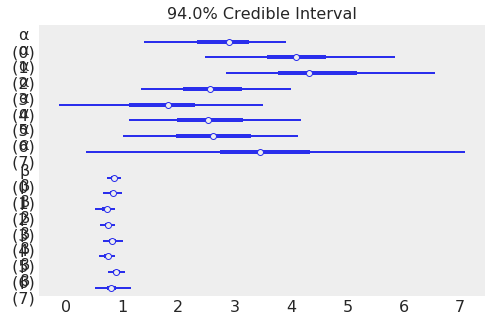

In [22]:
az.forestplot(trace_hm, var_names=['α', 'β'], figsize=(8, 5), combined=True, r_hat=False, n_eff=False);

Let's plot the fitted lines, for each one of the eight groups.

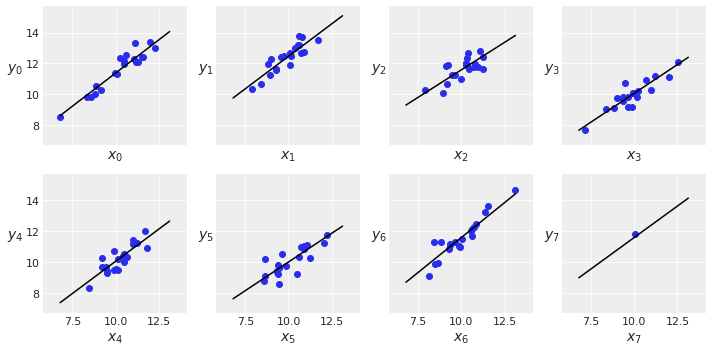

In [23]:
# add uncertainty
_, ax = plt.subplots(2, 4, figsize=(10,5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel('$x_{}$'.format(i))
    ax[i].set_ylabel('$y_{}$'.format(i), labelpad=10, rotation=0)
    alfa_m = trace_hm['α'][:,i].mean()
    beta_m = trace_hm['β'][:,i].mean()
    ax[i].plot(x_range, alfa_m + beta_m * x_range, c='k',
             label='y = {:.2f} + {:.2f} * x'.format(alfa_m, beta_m))
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N
plt.tight_layout();

## Regresión polinomial


Ahora vamos a aprender cómo ajustar curvas usando una regresión lineal. Una manera de ajustar curvas usando un modelo de regresión lineal es construyendo un polinomio como este:

$$\mu = \beta_0 x^0 + \beta_1 x^1  \dots + \beta_m x^m \tag{3.12} $$

Si prestamos atención, podemos ver que este polinomio _esconde_  un modelo lineal simple. De hecho si hacemos que $\beta_n = 0$ para $n \gt 1$ obtendremos:

$$\mu = \beta_0 + \beta_1 x^1 \tag{3.13} $$

Que no es otra cosa que la ecuación de una recta. Una regresión polinomial sigue siendo una regresión lineal, ya que la linearidad del modelo está relacionada con la forma en que los parámetros entran en el modelo y no con las variables. Probemos construyendo una regresión polinomial de grado 2.

$$\mu = \beta_0 + \beta_1 x^1 + \beta_2 x^2 \tag{3.14} $$

El tercer término controla la curvatura de la relación como veremos a continuación.

Como un conjunto de datos, vamos a utilizar el segundo grupo del cuarteto de Anscombe.

In [24]:
x_2 = ans[ans.group == 'II']['x'].values
x_2.mean()

9.0

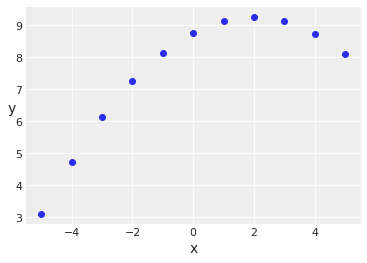

In [25]:
#ans = pd.read_csv('anscombe.csv')
x_2 = ans[ans.group == 'II']['x'].values
y_2 = ans[ans.group == 'II']['y'].values
x_2 = x_2 - x_2.mean()
#y_2 = y_2 - y_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0);

In [26]:
with pm.Model() as model_poly:
    α = pm.Normal('α', mu=y_2.mean(), sd=1)
    β1 = pm.Normal('β1', mu=0, sd=1)
    β2 = pm.Normal('β2', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)

    mu = α + β1 * x_2 + β2 * x_2**2
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=ϵ, observed=y_2)
    
    trace_poly = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β2, β1, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:05<00:00, 962.23draws/s] 
The acceptance probability does not match the target. It is 0.917733125963838, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9092922862575084, but should be close to 0.8. Try to increase the number of tuning steps.


Once again, we are going to omit some checks and summaries and just plot the results, a nice curved line fitting the data almost with no errors. Take into account the minimalistic nature of the dataset.

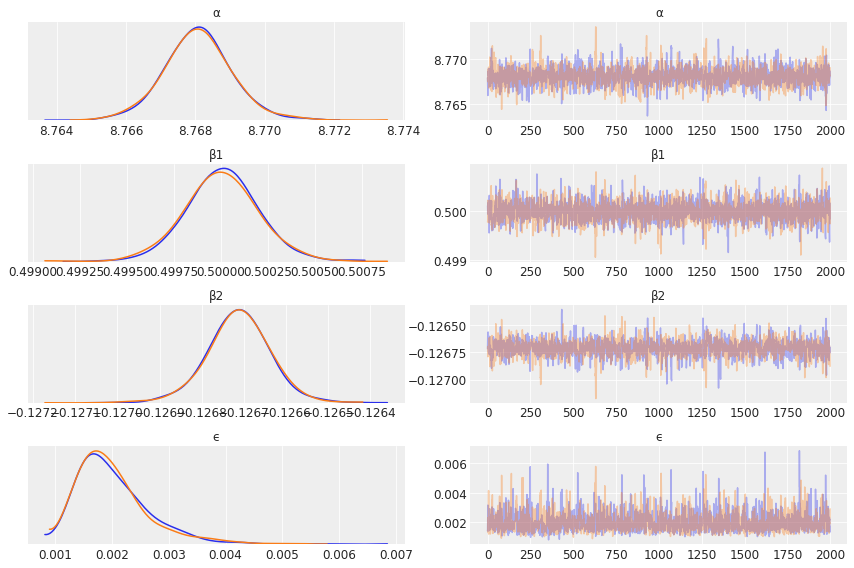

In [27]:
az.traceplot(trace_poly);

In [28]:
az.summary(trace_poly)

<xarray.Dataset>
Dimensions:  (metric: 7)
Coordinates:
  * metric   (metric) <U22 'mean' 'standard deviation' 'mc error' ...
Data variables:
    α        (metric) float64 8.768 0.0009854 9.597e-06 8.766 8.77 1.565e+03 1.0
    β1       (metric) float64 0.5 0.000197 2.861e-06 0.4996 0.5004 2.686e+03 1.0
    β2       (metric) float64 -0.1267 7.481e-05 4.532e-07 -0.1269 -0.1266 ...
    ϵ        (metric) float64 0.002015 0.0006508 1.083e-05 0.001117 0.00324 ...

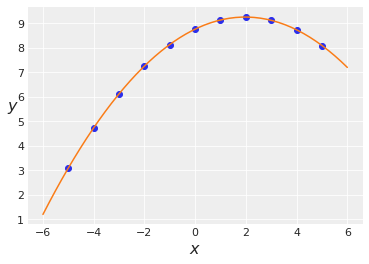

In [29]:
x_p = np.linspace(-6, 6)
y_p = trace_poly['α'].mean() + trace_poly['β1'].mean() * x_p + trace_poly['β2'].mean() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x_p, y_p, c='C1');

### Interpretando los parámetros de una regresión polinomial

Uno de los problemas de la regresión polinómica es la interpretación de sus parámetros. Si queremos saber cómo cambia $y$ por unidad de cambio de $x$, no podemos simplemente verificar el valor de $\beta_1$, ya que $\beta_2$, y los coeficientes más altos (de estar presentes), tendrán un efecto en dicha cantidad. Entonces los coeficientes $\beta$ ya no son pendientes, son otra cosa. En el ejemplo anterior, $\beta_1$ es positivo y, por lo tanto, la curva comienza con una pendiente positiva, pero $\beta_2$ es negativo y, por lo tanto, después de un tiempo, la línea comienza a curvarse hacia abajo. Es como si tuviéramos dos fuerzas en juego, una empujando la línea hacia arriba y la otra hacia abajo. La interacción depende del valor de $x$. Cuando $x \lessapprox 11$ (en la escala original, o 2 en la escala centrada), la contribución dominante proviene de $\beta_1$, y cuando $x \gtrapprox 11$, entonces $\beta_2$ domina.

El problema de interpretar los parámetros no es solo un problema matemático, ya que esto se puede resolver mediante una inspección cuidadosa del modelo. El problema es que, en muchos casos, los parámetros no se traducen a cantidades que tengan sentido a la luz de nuestro conocimiento de dominio. Es decir no podemos relacionarlos con la tasa metabólica de una célula, la energía emitida por una galaxia o el número de habitaciones en una casa. Los parámetros terminan siendo simplemente perillas que podemos manipular para mejorar el ajuste pero sin un significado claro. En la práctica, la mayoría de la gente suele estar de acuerdo en que los polinomios de orden superior a dos o tres generalmente no son modelos muy útiles y se prefieren alternativas, quizá como los Procesos Gaussianos.


## Regresión lineal Multiple


Hasta ahora hemos estado trabajando con una variable dependiente y una variable independiente, sin embargo no es inusual tener varias variables independientes que queremos incluir en nuestro modelo. Algunos ejemplos podrían ser:

* Calidad percibida del vino (dependiente) y acidez, densidad, nivel de alcohol, azúcar residual y contenido de sulfatos (variables independientes)
* Calificaciones promedio de los estudiantes (dependientes) e ingresos familiares, distancia de la casa a la escuela y educación de la madre (variable categórica)

Podemos extender fácilmente el modelo de regresión lineal simple para tratar con más de una variable independiente. Llamamos a este modelo regresión lineal múltiple, que no debe confundirse con la regresión lineal multivariada, que corresponde con el caso de múltiples variables dependientes.

En una regresión lineal múltiple modelamos la media de la variable dependiente como:

$$\mu = \alpha + \beta_1 x_1 + \beta_2 x_2 \dots + \beta_m x_m \tag{3.15}$$

La expresión 3.15 se parece a una regresión polinomial (ecuación 3.12), pero no es exactamente lo mismo. Para la regresión lineal múltiple tenemos diferentes variables independientes en lugar de potencias sucesivas de la misma variable independiente. Desde el punto de vista de la regresión lineal múltiple, podemos decir que una regresión polinomial es como una regresión lineal múltiple pero con variables _inventadas_.

Usando la notación de álgebra lineal, podemos escribir una versión más corta:

$$\mu = \alpha + X \beta \tag{3.16}$$


Donde $\beta$ es un vector de coeficientes de longitud $m$, es decir, el número de variables dependientes. La variable $X$ es una matriz de tamaño $m \times n$ si $n$ es el número de observaciones y $m$ es el número de variables independientes. Si estás un poco oxidado con el álgebra lineal, puedes consultar el artículo de Wikipedia sobre el producto escalar entre dos vectores y su generalización a la multiplicación de matrices. Básicamente lo que necesitamos saber por el momento es que estamos usando una forma más corta y conveniente de escribir nuestro modelo:

$$X \beta = \sum_{i=1}^n \beta_ix_i = \beta_1 x_1 + \beta_2 x_2 \dots + \beta_m x_m \tag{3.17} $$

Usando el modelo de regresión lineal simple, encontramos una línea recta que (con suerte) explica nuestros datos. Bajo el modelo de regresión lineal múltiple, encontramos, en cambio, un hiperplano de dimensión $m$. Por lo tanto, el modelo de regresión lineal múltiple es esencialmente el mismo modelo de regresión lineal simple, la única diferencia es que ahora $\beta $ es un vector y $X$ es una matriz.

Vamos a definir nuestros datos:

In [30]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i,j in zip([10, 2], [1, 1.5])]).T
X_mean = X.mean(axis=0, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(X, beta_real) + eps_real

A continuación vamos a definir una función que realiza tres gráficos de dispersión, dos entre cada variable independiente y la variable dependiente y el último entre ambas variables dependientes. Usaremos esta función para ayudarnos durante el resto del capítulo:

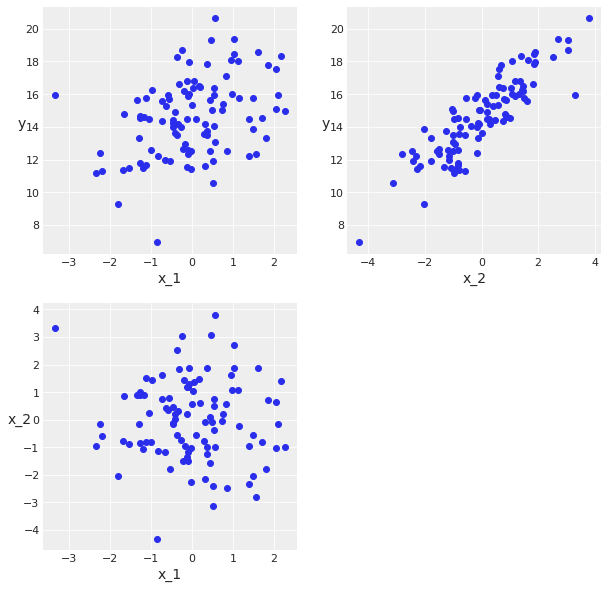

In [31]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x.T):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel('x_{}'.format(idx+1))
        plt.ylabel('y', rotation=0)

    plt.subplot(2, 2, idx+2)
    plt.scatter(x[:,0], x[:,1])
    plt.xlabel('x_{}'.format(idx))
    plt.ylabel('x_{}'.format(idx+1), rotation=0)

scatter_plot(X_centered, y);

Ahora si vamos a definir en PyMC3 un modelo adecuado para la regresión lineal múltiple. Como es de esperar el código luce muy similar al modelo de regresión lineal simple. Las principales diferencias son:

* La variable $\beta$ es Gaussiana con `shape = 2`, es decir una pendiente por cada variable independiente.
* La variable $\mu$ la definimos usando la función `pm.math.dot()`

Si estás familiarizado con NumPy, probablemente sepas que NumPy también incluye una función para multiplicar matrices `np.dot` y desde Python 3.5 (y desde NumPy 1.10) existe un nuevo operador para multiplicar matrices `@`. Sin embargo, aquí usamos la función de PyMC3, que no es más que un alias para el operador de multiplicación de matrices de Theano. Necesitamos hacer esto porque la variable $\beta$ es un tensor de Theano y no un array de NumPy.

In [32]:
with pm.Model() as model_mlr:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α_tmp + pm.math.dot(X_centered, β)

    α = pm.Deterministic('α', α_tmp - pm.math.dot(X_mean, β)) 

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    
    trace_mlr = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α_tmp]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1271.74draws/s]


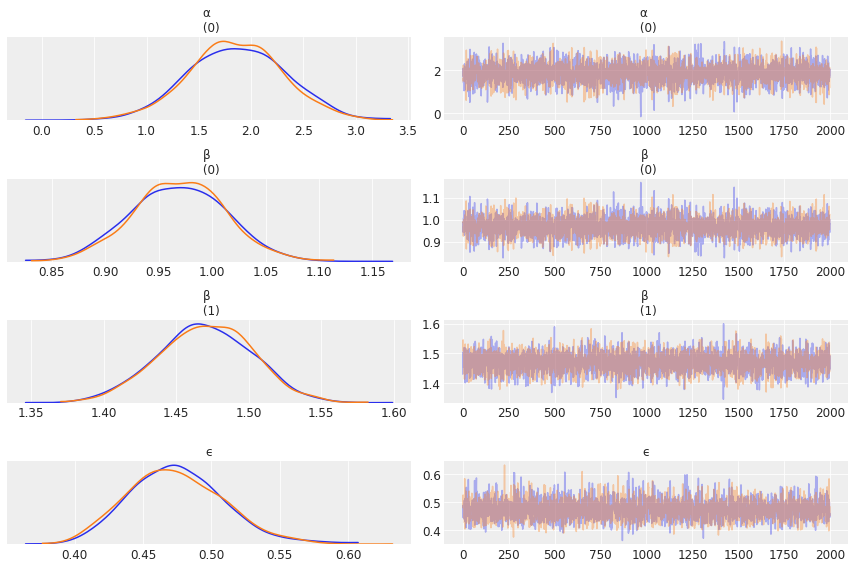

In [33]:
var_names = ['α', 'β','ϵ']
az.traceplot(trace_mlr, var_names);

In [56]:
az.summary(trace_mlr, var_names).to_dataframe()

α            β            ϵ
metric                 α_dim_0 β_dim_0                                       
mean                   0       0           1.852921     0.968556     0.474118
                               1           1.852921     1.469562     0.474118
standard deviation     0       0           0.456194     0.043817     0.034820
                               1           0.456194     0.032396     0.034820
mc error               0       0           0.002403     0.000264     0.000444
                               1           0.002403     0.000363     0.000444
hpd 3.00%              0       0           1.052236     0.888450     0.407726
                               1           1.052236     1.406450     0.407726
hpd 97.00%             0       0           2.744339     1.052025     0.535157
                               1           2.744339     1.526409     0.535157
effective samples      0       0        5254.616407  5529.200516  4089.258285
                               1        5254.616407  5616.575197  4089.258285
gelman-rubin statistic 0       0           1.000000     1.000000     1.000000
                               1           1.000000     1.000000     1.000000

Como podemos ver, nuestro modelo es capaz de recuperar los valores correctos (verificalo comparando contra los valores utilizados para generar los datos sintéticos).

En las siguientes secciones, nos centraremos en algunas precauciones que debemos tomar al analizar los resultados de un modelo de regresión múltiple, especialmente la interpretación de las pendientes. El principal mensaje de la siguiente sección es que en una regresión lineal múltiple, cada uno de los parámetros solo tiene sentido en el contexto del resto de los parámetros.

## Variables de confusión y variables redundantes

Imagina la siguiente situación. Tenemos una variable $z$ correlacionada con la variable pronosticadora $x$ y, al mismo tiempo, con la variable dependiente $y$. Supongamos que la variable $z$ es la responsable de causar $x$ y $y$. Por ejemplo, $z$ podría ser la revolución industrial (¡una variable realmente compleja!), $x$ el número de piratas, e $y$ la concentración de $CO_2$, este ejemplo debería ser muy familiar para el lector de Pastafariano. Si omitimos $z$ de nuestro análisis, podríamos terminar con una buena relación lineal entre $x$ e $y$, incluso podríamos predecir $x$ a partir de $y$. Sin embargo, si nuestro interés radica en minimizar el calentamiento global, podríamos pasar por alto lo que realmente está sucediendo con el mecanismo subyacente que relaciona estas variables.

Lo que intento decir es la conocida expresión **correlación no implica causalidad**. Una razón por la que esto no es necesariamente cierto es que podemos estar omitiendo la variable $z$ de nuestro análisis. Cuando esto sucede, llamamos a $z$ [variable de confusión](https://en.wikipedia.org/wiki/Confounding) o factor de confusión. En muchos escenarios reales $z$ es fácil de perder de vista. Tal vez no la medimos o no estaba presente en el conjunto de datos que nos enviaron, o ni siquiera pensamos que $z$ podría estar relacionado con nuestro problema. No tomar en cuenta las variables de confusión en un análisis podría llevarnos a establecer correlaciones falsas. Esto siempre es un problema cuando tratamos de explicar algo y también puede ser problemático cuando tratamos de predecir algo sin preocuparnos por comprender el mecanismo subyacente. Comprender el mecanismo nos ayuda a traducir lo que hemos aprendido a situaciones nuevas; las predicciones ciegas no siempre tienen buena transferibilidad. Por ejemplo, la cantidad de zapatillas producidas en Argentina podría utilizarse como un indicador fácil de medir para estimar la fortaleza de su economía, pero podría ser un pésimo predictor para otros países con una matriz de producción o un contexto cultural diferente.

A continuación vamos a usar datos sintéticos para explorar un poco el concepto de variable de confusión. El siguiente código simula una variable de confusión como $x_1$. Observe cómo esta variable tiene influencias en $x_2$ y también en $y$:

In [57]:
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
#x_2 = x_1 + np.random.normal(size=N, scale=0.01)  
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

Debido a como generamos los datos estos ya están centrados como se puede ver en la siguiente figura:

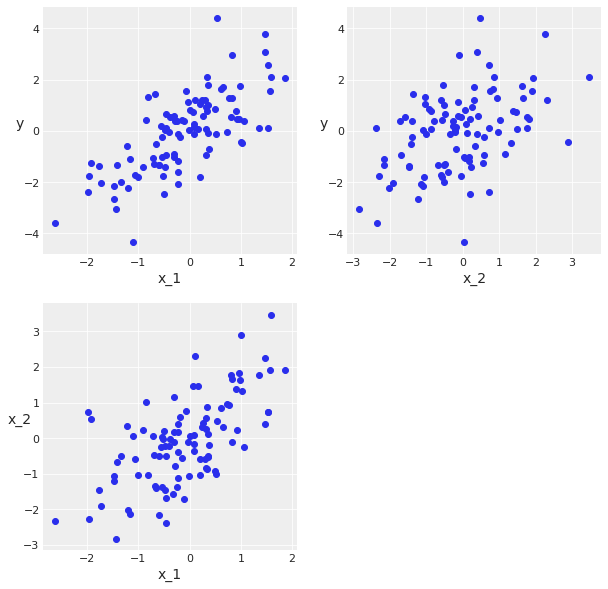

In [58]:
scatter_plot(X, y);

Ahora vamos a construir tres modelos relacionados, el primero `m_x1x2`, es un modelo de regresión lineal con dos variables independientes $x_1$ y $x_2$ (apilados en la variable $X$). El segundo modelo, `m_x1`, es una regresión lineal simple para y el tercero, `m_x2`, una regresión de línea simple para $x_2$:

In [59]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:,0] + β2 * X[:,1] 
    
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
 
    trace_x1x2 = pm.sample(2000)
    
    
with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:,0]
    
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
 
    trace_x1 = pm.sample(2000)
    
with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β2 * X[:,1]
    
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
 
    trace_x2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β2, β1, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:02<00:00, 1779.00draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β1, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:02<00:00, 2348.56draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β2, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:02<00:00, 2466.80draws/s]


A continuación usamos un forestplot a fin de comparar los valores de $\beta$ para estos 3 modelos.

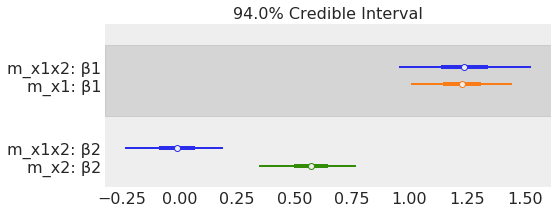

In [60]:
az.forestplot([trace_x1x2, trace_x1, trace_x2], model_names=['m_x1x2', 'm_x1', 'm_x2'], var_names=['β1', 'β2'],
              r_hat=0, n_eff=0, combined=1, colors='cycle',
              figsize=(8, 3));

Como podemos ver $\beta_2$ para el modelo `m_x1x2` es alrededor de cero, lo que indica una contribución casi nula de la variable $x_2$ para explicar $y$. Esto es interesante porque ya sabemos que la variable realmente importante es $x_1$ (como se puede verificar en la generación de datos sintéticos). También hay que notar, y esto es realmente importante, $\beta_2$ para el modelo `m_x2` es alrededor de 0.55, es decir es más grande que para el modelo `m_x1x2`. En otras palabras el poder de $x_2$ para predecir $y$ se reduce cuando tenemos en cuenta $x_1$, la información en $x_1$ es redundante dado $x_2$.


## Multicolinearidad o cuando la correlación es demasiado alta

Llevemos el ejemplo anterior a un extremo y veamos qué sucede cuando dos variables están altamente correlacionadas. Para estudiar este problema y sus consecuencias para la inferencia, utilizaremos los mismos datos y modelos sintéticos que antes, pero ahora aumentaremos el grado de correlación entre $x_1$ y $x_2$ al reducir la cantidad de _ruido Gaussiano_ que agregamos a $x_1$ para obtener $x_2$.

In [61]:
# Este es el mismo código de una celdas antes pero con una valor más bajo de `scale`
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=0.01)  
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

El cambio en la generación de datos, de la celda anterior, prácticamente equivale a sumar 0 a $x_1$, por lo tanto ambas variables son iguales para todo propósito práctico. A continuación, pueden intentar variar los valores de la desviación estándar y usar valores menos extremos, pero por ahora queremos que el efecto sea bien claro. En el siguiente gráfico se puede ver que ahora el diagrama de dispersión para $x_1$ y $x_2$ es prácticamente una línea recta con una pendiente alrededor de 1:

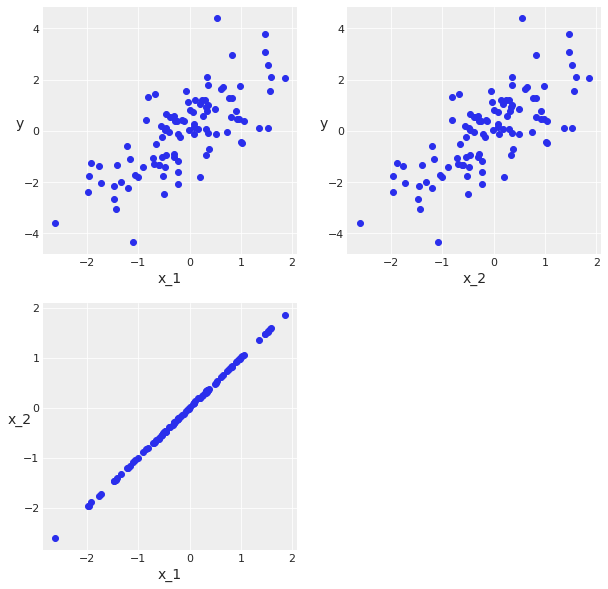

In [62]:
scatter_plot(X, y)

Ejecutamos una regresión lineal múltiple:

In [63]:
with pm.Model() as model_red :
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + pm.math.dot(X, β)
    
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
 
    trace_red = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:49<00:00, 101.53draws/s]
The acceptance probability does not match the target. It is 0.8970042475289574, but should be close to 0.8. Try to increase the number of tuning steps.


Y verificamos los resultados de los parámetros con un forestplot:

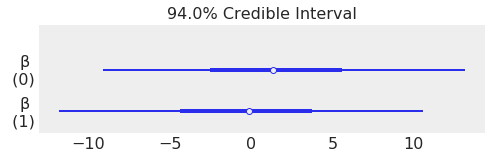

In [64]:
az.forestplot(trace_red, var_names=['β'], r_hat=0, n_eff=0, combined=1, figsize=(8, 2));

Los valores de los HPD para $\beta$ son sospechosamente amplios, podemos obtener una idea de lo que está sucediendo con un diagrama de dispersión de los coeficientes $\beta$

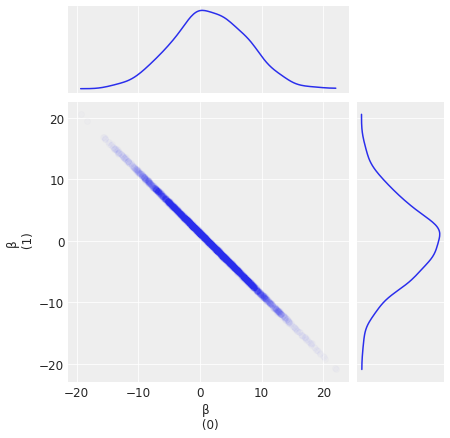

In [65]:
az.jointplot(trace_red, var_names=['β'], joint_kwargs={'alpha':0.01});

La distribución de los coeficientes $\beta$ es una diagonal realmente estrecha. Cuando un coeficiente $\beta$ sube, el otro debe bajar. Ambos están efectivamente correlacionados. Esto es solo una consecuencia del modelo y los datos. Según nuestro modelo, la media $\mu$ es:

$$ \mu = \alpha + \beta_1 x_1 + \beta_2 x_2 \tag{3.19} $$

Si suponemos que $x_1$ y $x_2$ no son prácticamente equivalentes, sino matemáticamente idénticos, podemos volver a escribir el modelo como:

$$ \mu = \alpha + (\beta_1 + \beta_2) x \tag{3.20} $$


Resulta que es la suma $\beta_1 + \beta_2$ y no sus valores separados, lo que afecta $\mu$. Podemos hacer que $\beta_1$ sea más pequeño y más pequeño siempre que hagamos que $\beta_2$ sea más y más grande. Los resultados nos están diciendo que como prácticamente NO tenemos dos variables $x$, prácticamente NO tenemos dos parámetros $\beta$. Decimos entonces que el modelo está **indeterminado** (o de forma equivalente, los datos no pueden restringir los parámetros en el modelo). En nuestro ejemplo, hay dos razones por las cuales $\beta$ no se mueve libremente en el intervalo $(-\infty, \infty)$. Primero, ambas variables son casi las mismas, pero no son exactamente iguales, en segundo lugar, y lo más importante, los _a prioris_ actuan como restricciones de los valores plausibles que $\beta$ puede tomar.

Hay un par de cosas que notar de este ejemplo. En primer lugar, el _a posteriori_ es tan solo la consecuencia lógica de los datos y el modelo, por lo tanto no hay nada _de malo_ en obtener distribuciones tan amplias para $\beta$, _C'est la vie_. En segundo lugar, podemos confiar en este modelo para hacer predicciones ya que los valores predichos por el modelo están de acuerdo con los datos, es decir el modelo captura los datos muy bien. En tercer lugar, este puede no ser un modelo muy bueno para comprender nuestro problema. Puede ser más inteligente simplemente eliminar una de las variables del modelo. Terminaremos teniendo un modelo que predice los datos igual que antes, pero con una interpretación más simple.

En cualquier conjunto de datos real, van a existir variables (parcialmente) correlacionadas. Esto sucede por al menos dos razones: la existencia de correlaciones espurias y quizá lo más relevante; al estudiar un problema tendemos a recolectar información que consideramos relevante pero que mucha de la cual es parcialmente redundante. Por ejemplo la cantidad de radiación solar, la temperatura y las precipitaciones son factores que influyen para predecir el rinde de un cultivo, y son variables que tienen a estar correlacionadas por ejemplo en Argentina el verano es la temporada húmeda.  

¿Qué tan fuerte deben correlacionarse dos o más variables para convertirse en un problema? Bueno se suele considerar que a partir de 0.9845. No, mentira! Desafortunadamente, la estadística es una disciplina con muy pocos números mágicos. Siempre es posible hacer una matriz de correlación antes de ejecutar cualquier modelo y verificar las variables con una alta correlación de, digamos por encima de 0.9 o más. Sin embargo, el problema con este enfoque es que lo que realmente importa no son las correlaciones por pares que podemos observar en una matriz de correlación, sino la correlación de las variables dentro de un modelo, y como ya vimos, las variables se comportan de forma diferente cuando están aisladas que cuando se relacionan dentro de un modelo. Dos o más variables pueden aumentar o disminuir su correlación cuando se colocan en el contexto de otras variables en un modelo de regresión múltiple. Como siempre, una inspección cuidadosa de la distribución _a posteriori_ junto con una aproximación iterativa y crítica del modelado, son muy recomendables y pueden ayudarnos a detectar problemas y comprender los datos y los modelos.

Solo como una guía rápida (a tomar con pinzas). ¿Qué deberíamos hacer si encontramos variables altamente correlacionadas?

* Si la correlación es realmente alta, podemos eliminar una de las variables del análisis; dado que ambas variables tienen información similar, cual eliminamos suele ser a menudo irrelevante. Podemos eliminar variables basadas en nuestra conveniencia, por ejemplo eliminar variables menos conocidas o más difíciles de interpretar o medir.
* Otra posibilidad es crear una nueva variable promediando las variables redundantes. Una versión más sofisticada es usar un algoritmo de reducción de variables como un análisis de componentes principales (PCA). El problema con PCA es que las variables resultantes son combinaciones lineales de las originales que ofuscan, en general, la interpretabilidad de los resultados.
* Otra solución es utilizar _a prioris_ más fuertes para restringir los valores plausibles que puede adoptar el coeficiente, en este contexto los _a prioris_ se usan como regularizadores de la inferencia (algo que discutiremos en el capítulo 5).

## Variables de efecto de enmascaramiento

Otro ejemplo de cómo las variables contribuyen a un resultado es el caso de las variables que enmascaran. Vamos a crear dos variables independientes ($x_1$ y $x_2$), las cuales están positivamente correlacionadas entre sí y están correlacionadas con $y$, pero en direcciones opuestas $x_1$ está correlacionada positivamente y $x_2$ correlacionada negativamente.

In [44]:
np.random.seed(42)
N = 126
r = 0.8
x_1 = np.random.normal(size=N)
x_2 = np.random.normal(x_1, scale=(1 - r ** 2) ** 0.5)
y = np.random.normal(x_1 - x_2)
X = np.vstack((x_1, x_2)).T

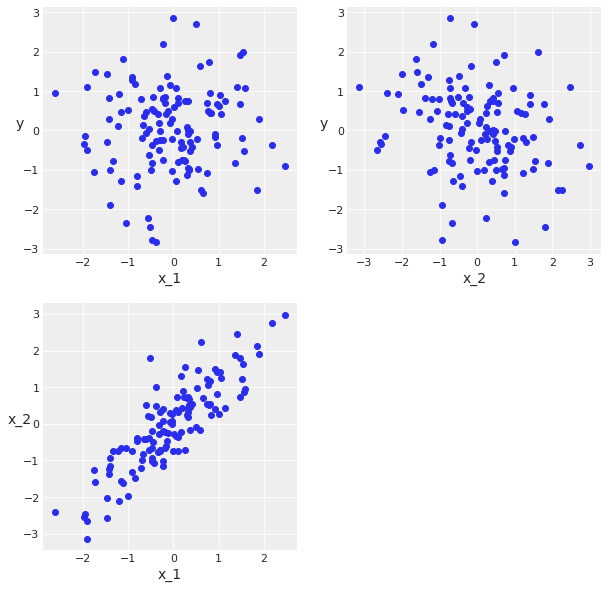

In [45]:
scatter_plot(X, y);

In [46]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:,0] + β2 * X[:,1] 
    
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
 
    trace_x1x2 = pm.sample(1000)
    
    
with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:,0]
    
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
 
    trace_x1 = pm.sample(1000)
    
with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β2 * X[:,1]
    
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
 
    trace_x2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β2, β1, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1207.06draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β1, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2028.46draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β2, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2025.75draws/s]


Como hicimos antes, vamos a construir 3 modelos relacionados, el primero m_x1x2, es un modelo de regresión lineal con dos variables independientes $x_1$ y $x_2$ (_apilados_ en la variable X). El segundo modelo, m_x1, es una regresión lineal simple para $x_1$ y el tercero, m_x2, una regresión lineal simple para $x_2$. Después de tomar muestras de estos modelos, eche un vistazo a los parámetros $\beta$ usando un `forestplot` para compararlos en un solo diagrama.

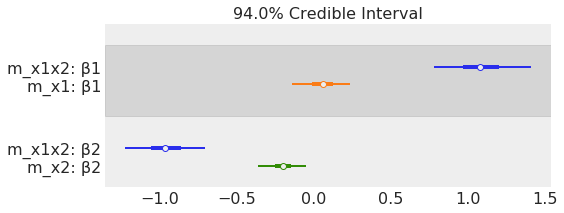

In [47]:
az.forestplot([trace_x1x2, trace_x1, trace_x2], model_names=['m_x1x2', 'm_x1', 'm_x2'],
              var_names=['β1', 'β2'], r_hat=0, n_eff=0, combined=1, colors='cycle',
              figsize=(8, 3));

## Agregar interacciones

Hasta ahora, en la definición del modelo de regresión múltiple, se declara (implícitamente) que un cambio en $x_i$ da como resultado un cambio constante en $y$ manteniendo los valores fijos para el resto de las variables de predicción. Pero, por supuesto, esto no es necesariamente cierto. Podría suceder que los cambios en $x_i$ afecten $y$ modulados por cambios en $x_j$. Un ejemplo clásico de este comportamiento es la interacción entre drogas. Por ejemplo, aumentar la dosis del fármaco A resulta en un efecto positivo en un paciente. Esto es cierto en ausencia de fármaco B (o para dosis bajas de B) mientras que el efecto de A es negativo (incluso letal) al aumentar las dosis de B.

En todos los ejemplos que hemos visto hasta ahora, las variables dependientes contribuyen aditivamente a la variable predicha, solo agregamos variables (cada una multiplicada por un coeficiente). Si deseamos capturar efectos, como en el ejemplo de la droga, necesitamos incluir términos en nuestro modelo que no sean aditivos. Una opción común es multiplicar variables, por ejemplo:

$$\mu = \alpha + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1x_2 \tag{3.21} $$

Observe que el coeficiente $\beta_3$ está multiplicando una tercera variable que es el producto de $x_1$ y $x_2$. Este término no aditivo es un ejemplo de lo que se conoce en las estadísticas como **interacción**. Hay otras maneras de introducir interacciones, pero vamos a restringir la discusión al caso multiplicativo, ya que es la expresión más común para las interacciones.

Interpretar modelos lineales con interacciones no es tan fácil como interpretar modelos lineales sin ellos. Reescribamos la expresión 3.21.

$$
\mu = \alpha + \underbrace{{(\beta_1 + \beta_3} x_2)} _ {\text{slope} x_1} x_1 + \beta_2 x_2 \\
\mu = \alpha + \beta_1 x_1 + \underbrace{(\beta_2 + \beta_3 x_1)} _ {\text{pendiente} x_2} x_2 \\ \tag{3.22}
$$

Esto muestra que:

* El término de interacción se puede entender como un modelo lineal. La expresión para la media, es un modelo lineal ¡Con un modelo lineal adentro!
* La interacción es simétrica, podemos considerarla como la pendiente de $x_1$ en función de $x_2$ y al mismo tiempo como la pendiente de $x_2$ en función de $x_1$.
* En un modelo de regresión múltiple sin interacciones obtenemos un hiperplano. Un término de interacción introduce una curvatura en tal hipersuperficie. Porque las pendientes ya no son constantes, sino una función de otra variable.
* El coeficiente $\beta_1$ describe la influencia del predictor $x_1$ solo cuando $x_2 = 0$. Esto es cierto porque para ese valor $\beta_3x_2 = 0$ y luego la pendiente de $x_1$ se reduce a $\beta1 x_1$. Por simetría, el mismo razonamiento se puede aplicar a $\beta_2$.

## Varianza variable

Hemos estado usando el modelo lineal para modelar la media de una distribución, dejando la varianza de lado. En caso que consideremos que el supuesto de varianza constante no tiene sentido podemos considerar la varianza como una función (lineal) de la variable dependiente.

La Organización Mundial de la Salud y otras instituciones de salud de todo el mundo recopilan datos para recién nacidos y adultos mayores y diseñan estándares de gráficos de crecimiento. Estas tablas son un componente esencial del conjunto de herramientas pediátricas y también como una medida del bienestar general de las poblaciones con el fin de formular políticas de salud, planificar intervenciones y controlar su eficacia. Un ejemplo de tales datos son la longitud (alturas) de las niñas recién nacidas en función de la edad (en meses):

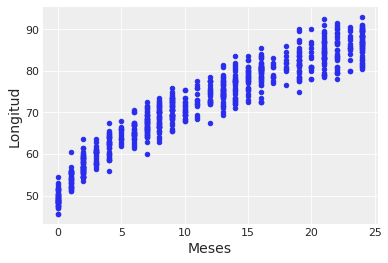

In [49]:
data = pd.read_csv('datos/babies.csv')
data.plot.scatter('Meses', 'Longitud');

Para modelar estos datos, presentaremos 3 elementos nuevos en comparación con los modelos anteriores:

* $\epsilon$ ahora es una función lineal de $x$, y para hacer esto agregamos dos nuevos parámetros $\gamma$ y $\delta$, estos son análogos directos de $\alpha$ y $\beta$.
* El modelo lineal para la media es una función de $\sqrt{x}$, esto es solo un truco simple para ajustar un modelo lineal a una curva.
* Hemos definido una variable compartida (`x_shared`, esto nos permitirá cambiar los valores de la variable $x$ (`Meses` en este ejemplo) sin la necesidad de volver a muestrear el modelo. Por qué hacemos estos será evidente pronto si tienen un poco de paciencia.

In [50]:
with pm.Model() as model_vv:
    α = pm.Normal('α', sd=10)
    β = pm.Normal('β', sd=10)
    γ = pm.HalfNormal('γ', sd=10)
    δ = pm.HalfNormal('δ', sd=10)
    
    x_shared = shared(data.Meses.values * 1.)

    μ = pm.Deterministic('μ', α + β * x_shared**0.5)
    ϵ = pm.Deterministic('ϵ', γ + δ * x_shared)
    
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=data.Longitud)
    
    trace_vv = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [δ, γ, β, α]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 747.06draws/s]


La siguiente figura muestra el resultado de nuestro modelo. La media de es $\mu$ representada con una curva negra, y dos bandas naranja semitransparentes representan 1 y 2 desviaciones estándar.

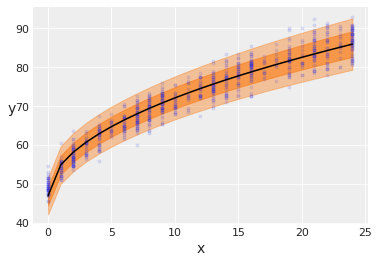

In [51]:
plt.plot(data.Meses, data.Longitud, 'C0.', alpha=0.1);

μ_m = trace_vv['μ'].mean(0)
ϵ_m = trace_vv['ϵ'].mean(0)

plt.plot(data.Meses, μ_m, c='k')
plt.fill_between(data.Meses, μ_m + 1 * ϵ_m, μ_m - 1 * ϵ_m, alpha=0.6, color='C1')
plt.fill_between(data.Meses, μ_m + 2 * ϵ_m, μ_m - 2 * ϵ_m, alpha=0.4, color='C1')

plt.xlabel('x')
plt.ylabel('y', rotation=0);

Ahora que tenemos ajustado el modelo podríamos querer averiguar como se compara la longitud de una niña en particular con el modelo. Una forma de responder a esta pregunta es preguntarle al modelo por la distribución de la variable _longitud_ para bebas de digamos de 0.5 meses. Usando PyMC3 podemos hacer estas preguntas con la función sample_ppc, ya que esto arrojará muestras de $\tilde y$ es decir los valores predichos considerando la incertidumbre de los parámetros. El único problema es que, por defecto, esta función devolverá valores de $\tilde y$ para los valores observados de $x$ y de 0,5 meses (el valor que me importa) no es parte de los datos originales. La manera más fácil de obtener predicciones para valores no observados de es definir una variable compartida $x$ (como parte del modelo) y luego actualizar el valor de la variable compartida justo antes del muestreo de la distribución predictiva _a posteriori_.

In [52]:
x_shared.set_value([0.5, 1])
ppc = pm.sample_posterior_predictive(trace_vv, 2000, model=model_vv)
y_ppc = ppc['y_pred'][:,0]

100%|██████████| 2000/2000 [00:01<00:00, 1008.71it/s]


Ahora podemos graficar la distribución esperada de las longitudes para las bebas con 2 semanas de vida y calcular cantidades adicionales, por ejemplo, el percentil de un niño para su longitud:

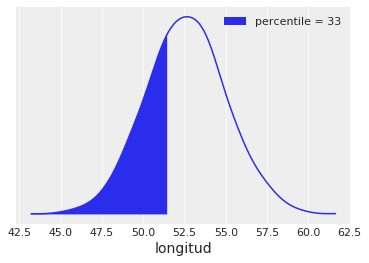

In [53]:
ref = 51.5
density, l, u = az.plots._fast_kde(y_ppc)
x_ = np.linspace(l, u, 200)
plt.plot(x_, density)
percentile = int(sum(y_ppc <= ref) / len(y_ppc) * 100)
plt.fill_between(x_[x_ < ref], density[x_ < ref], label='percentile = {:2d}'.format(percentile))
plt.xlabel('longitud')
plt.yticks([])
plt.legend();

Los modelos lineales son muy comunes y son una familia más extensa que la vista hasta ahora (como veremos en el próximo capítulo). Por esa razón, PyMC3 incluye un módulo que simplifica la creación de modelos lineales generalizados (el nombre quedará claro en el próximo capítulo). Por ejemplo, una regresión lineal simple se puede especificar como:

```python
With pm.Model () como modelo:
    glm.glm ('y ~ x', datos)
    trace = sample (2000)
```

La segunda línea del código anterior se ocupa de agregar priors (planos XXXX !!!!!) predeterminados para la intersección y para la pendiente y una Gaussiana como _likelihood_. Lo cual está bien si solo desea ejecutar una regresión lineal predeterminada. Tenga en cuenta que el MAP de este modelo será esencialmente equivalente al obtenido utilizando el método (frecuentista) de mínimos cuadrados. De ser necesario, también es posible usar el módulo glm y cambiar los _a prioris_ y el _likelihood_. La sintaxis está tomada de paquetes de R, donde 'y ~ x' especifica que tenemos una variable $y$ que queremos estimar como una función lineal de $x$. 

## Resumen

Una regresión lineal simple es un modelo que puede usarse para predecir / explicar una variable desde otra. El uso de lenguaje de aprendizaje automático es un caso de aprendizaje supervisado. Desde una perspectiva probabilítica, un modelo de regresión lineal es una extensión del modelo de Gauss donde la media no se estima directamente, sino que se calcula como una función lineal de una variable de predicción y algunos parámetros adicionales. Si bien la distribución gaussiana es la opción más común para la variable dependiente, somos libres de elegir otras distribuciones. Una alternativa, especialmente útil cuando se trata de posibles valores atípicos, es la distribución t de Student. También aprendemos sobre el coeficiente de correlación de Pearson, la medida más común de la correlación lineal entre dos variables, cómo calcular una versión bayesiana a partir de los datos y muestras predictivas posteriores y su conexión a la distribución gaussiana multivariada. Una forma útil de expandir el modelo de regresión lineal es haciendo una versión jerárquica de él. Esto es muy simple de lograr con PyMC3 y obtenemos los beneficios de shirngake. También, brevemente, la importancia de no interpretar la correlación como causalidad. Por sorprendente que pueda parecer, podemos usar modelos lineales para ajustar las curvas, lo mostramos con dos ejemplos de regresión polinomial y tomando la raíz cuadrada de la variable independiente. La regresión lineal simple se puede extender fácilmente para tratar con más de una variable independiente en lo que generalmente se llama regresión lineal múltiple. Se requieren algunas precauciones para evitar errores y problemas para interpretar este tipo de modelos. Otras formas de utilizar el motivo lineal es modelar las interacciones y tratar con una varianza no constante para la variable dependiente. En el próximo capítulo, veremos cómo extender el modelo de regresión lineal para clasificar los datos.